# Weighted ECM clustering vs Traditional ECM clustering
## LettersIJL dataset


In [1]:
## Importing
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy as np
from evclust.utils import plotting, display_results_fuzzy_partition, display_results_evidential, ev_plot_2D
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
from evclust.datasets import load_letters

from evclust.ecm import ecm
from evclust.wecm_new_barycenter import wecm
from evclust.fcm.fcm_keller2000 import fcm as fcm_keller2000
from evclust.fcm.fcm_wang2004 import fcm as fcm_wang2004
from evclust.fcm.fcm_frigui2004 import scad1
from evclust.fcm.fcm_frigui2004 import scad2
from evclust.fcm.ifwfcm_xing2014 import fcm as ifwfcm_xing2014
from evclust.fcm.ifwfcm_kd_xing2014 import fcm as ifwfcm_kd_xing2014


Instances 227 - Features 16 - Class 3
     A    B    C    D    E    F    G    H    I     J    K    L    M    N    O  \
0  3.0  7.0  3.0  5.0  1.0  1.0  1.0  5.0  5.0   0.0  1.0  6.0  0.0  8.0  0.0   
1  3.0  4.0  4.0  7.0  1.0  0.0  1.0  6.0  6.0   0.0  0.0  6.0  0.0  8.0  0.0   
2  0.0  0.0  0.0  1.0  0.0  7.0  7.0  4.0  4.0   7.0  6.0  8.0  0.0  8.0  0.0   
3  1.0  4.0  2.0  3.0  1.0  9.0  6.0  2.0  6.0  12.0  4.0  9.0  1.0  7.0  1.0   
4  1.0  7.0  0.0  4.0  0.0  7.0  7.0  4.0  4.0   7.0  6.0  8.0  0.0  8.0  0.0   

     P  
0  8.0  
1  8.0  
2  8.0  
3  7.0  
4  8.0  


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


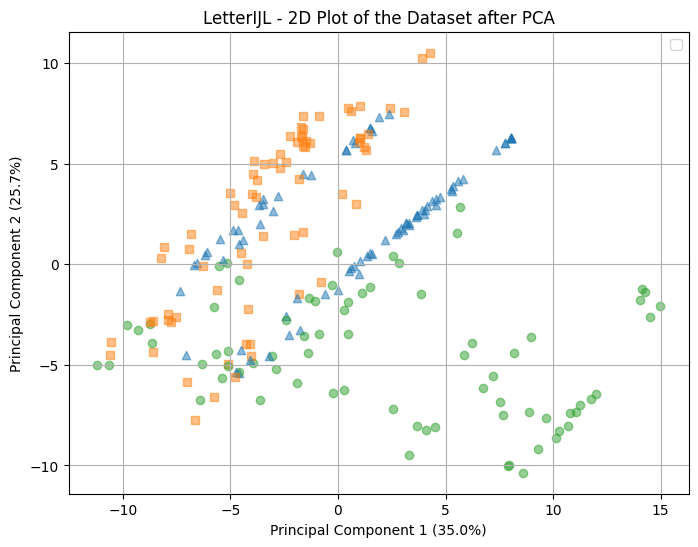

In [2]:
# fetch dataset
df = load_letters()

# data (as pandas dataframes)
y = pd.DataFrame(df.iloc[:, -1])
X = df.iloc[:, :-1]
c = 3

label_column_nm = y.columns[0]
labels_encoder = LabelEncoder()
numeric_labels = labels_encoder.fit_transform(y[label_column_nm])

markers = ['^', 's', 'o']
plotting(X, y, "LetterIJL", matrix_plot=False, markers=markers)

# Normalization
scaler = MinMaxScaler((0, 1))
X = pd.DataFrame(scaler.fit_transform(X))

## Traditional ECM

In [17]:
%%capture
# Traditional ECM clustering
delta = np.sqrt(20)
ecm_models = np.array([])
for i in range(10):
    model = ecm(x=X, c=c, beta=2, alpha=1, delta=delta, init="None", epsi=1e-5)
    ecm_models = np.append(ecm_models, model)

ecm_models = sorted(ecm_models, key=lambda x : x['crit'])

J values: [35.73174340108119, 35.73174562574282, 35.73178055308324, 35.73178842880505, 35.73178864798118, 35.73183122804567, 35.73183419509447, 35.73184592274461, 35.73184743610857, 35.731856129910696]
ARI values: [0.16398157976515212, 0.16398157976515212, 0.16582690275087345, 0.16582690275087345, 0.16479213783340735, 0.16582690275087345, 0.1726983392890527, 0.1726983392890527, 0.1726983392890527, 0.1726983392890527]
NS values: [1.4561525710167027, 1.4187392554076335, 1.4186528944826793, 1.4139564108787788, 1.4404665806737973, 1.4336180845920359, 1.4186990283556544, 1.413922572967337, 1.4186787113365027, 1.4565638683694806]
NMI values: [0.1550027545174985, 0.1550027545174985, 0.157708441314547, 0.157708441314547, 0.15620218150225298, 0.157708441314547, 0.16429541868878075, 0.16429541868878075, 0.16429541868878075, 0.16429541868878075]


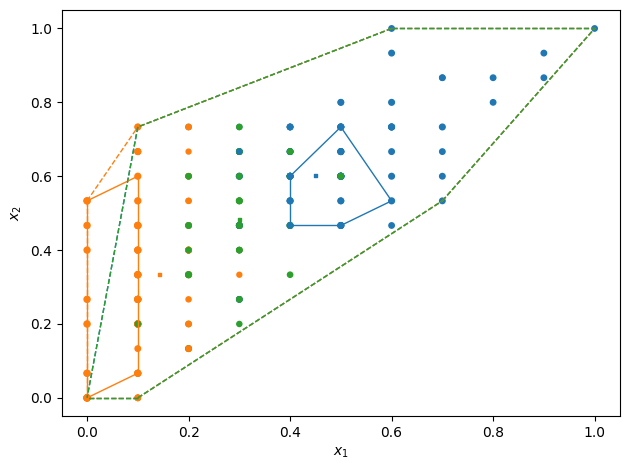

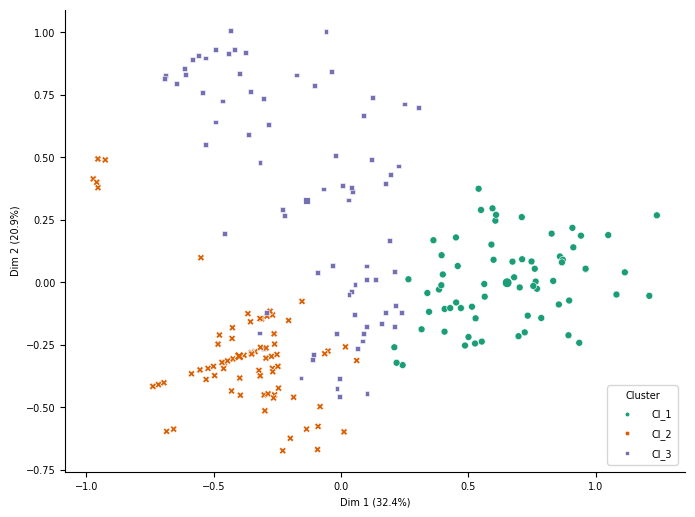

In [18]:
display_results_evidential(X, ecm_models, numeric_labels)

## Weighted ECM (WECM)

In [76]:
%%capture
wecm_models = np.array([])
d = X.shape[1]
delta = np.sqrt(20)
for i in range(10):
    model = wecm(x=X, c=c, beta=2, alpha=1, delta=delta, epsilon=1e-5, init="None")
    wecm_models = np.append(wecm_models, model)

wecm_models = sorted(wecm_models, key=lambda model: model['crit'])

J values: [0.008789847392836617, 0.008823486905856534, 0.010494204854036175, 0.020940454963534423, 0.024303090475615734, 0.027686904594254134, 0.03113921287322737, 0.03292858358736547, 0.03436344379557291, 0.03436363097884149]
ARI values: [0.1186081110534714, 0.1186081110534714, 0.0722554929874943, 0.06688708028753076, 0.13180982621360585, 0.08318204295467062, 0.17090543125061514, 0.053115855865815645, 0.06563608179396124, 0.06563608179396124]
NS values: [1.2224124718467535, 1.1982901996009716, 1.0579884793027476, 1.4888588123925721, 1.061244177712404, 1.307107523402359, 1.5250431244591682, 1.1770263357682016, 0.5357284282211923, 0.6446005789934085]
NMI values: [0.11857553835091694, 0.11857553835091693, 0.0769481660729331, 0.06129962461223724, 0.12928292633280425, 0.09114154416661172, 0.15057222887080016, 0.05058988026329819, 0.06012130133222861, 0.06012130133222861]


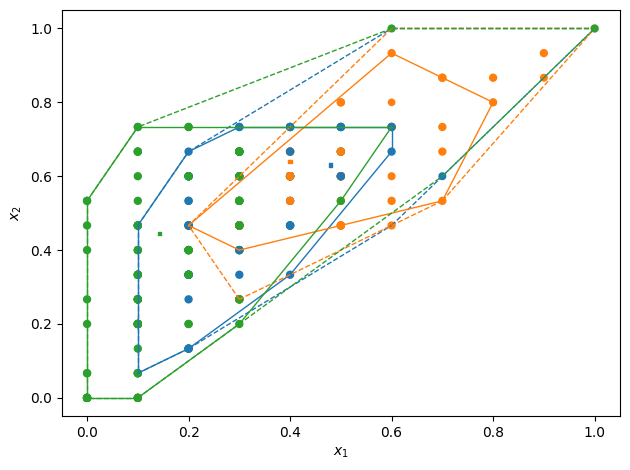

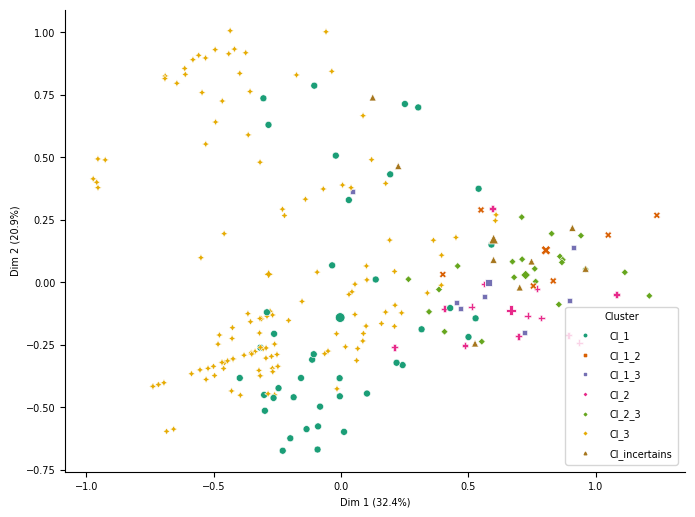

In [77]:
display_results_evidential(X, wecm_models, numeric_labels)

# Weighted FCM - Keller et al. 2000

In [51]:
%%capture
keller_models = np.array([])
# w0 = np.ones((c, X.shape[1])) / X.shape[1]
for i in range(10):
    model = fcm_keller2000(X, c=c, verbose=True, init="None")
    keller_models = np.append(keller_models, model)
keller_models = sorted(keller_models, key = lambda model : model['obj_func'])

J values: [0.08341072017255101, 0.10240043942860078, 0.10249557924063435, 0.10273175980382115, 0.11077023160218147, 0.13727259838886188, 0.13744914924879864, 0.1375362821449853, 0.14404834168267233, 0.15507300708147606]
ARI values: [0.1367371072313062, 0.06459926866535472, 0.06443329976341457, 0.06459048540616646, 0.08300960971905631, 0.1952249969624554, 0.19204039838233025, 0.19204039838233025, 0.2243195586266546, 0.0654907807799315]
NMI values: [0.13768004168869144, 0.05914159336376956, 0.058930176269945955, 0.05964463700729185, 0.08356534147566573, 0.18054015212679766, 0.17565912987978882, 0.17565912987978882, 0.20424079491660166, 0.0782496469165575]


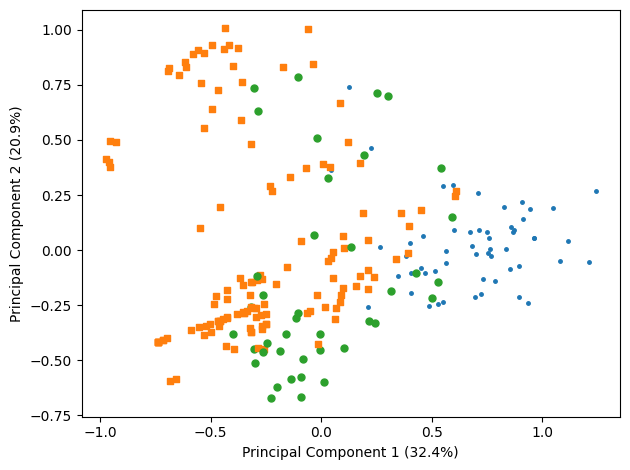

In [52]:
display_results_fuzzy_partition(X, keller_models, numeric_labels)

# Weighted FCM Wang 2004

In [72]:
%%capture
wang_models = np.array([])
for i in range(2):
    model = fcm_wang2004(X, c, w_beta=1.85, verbose=True, init="None")
    wang_models = np.append(wang_models, model)
wang_models = sorted(wang_models, key = lambda model : model['obj_func'])

J values: [6.562388202562138, 6.643357827961733]
ARI values: [0.27766782985910393, 0.2694220992234681]
NMI values: [0.362721454855064, 0.3517522364887897]


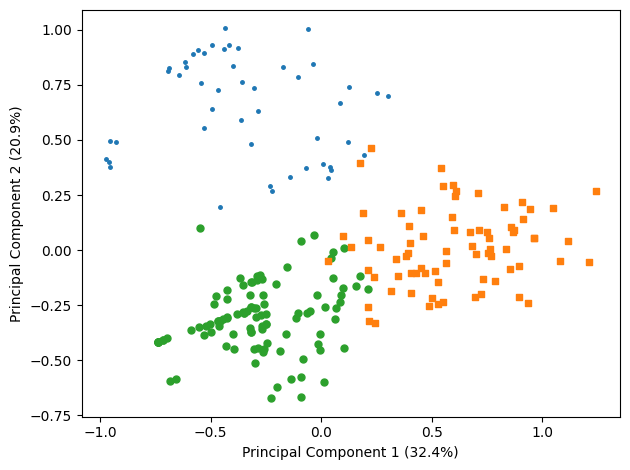

In [73]:
display_results_fuzzy_partition(X, wang_models, numeric_labels)

# SCAD1

In [55]:
%%capture
scad1_models = np.array([])
for i in range(10):
    model = scad1(X, c, verbose=True, epsilon=1e-5, init="None")
    scad1_models = np.append(scad1_models, model)
scad1_models = sorted(scad1_models, key = lambda model : model['obj_func'])


J values: [10.458393388873912, 10.458493277592538, 10.45849734781501, 10.458592005602725, 10.45859234921599, 10.458593094291967, 10.458594430904473, 10.45859563059722, 10.458597202272705, 10.458597753521707]
ARI values: [0.1780407584112133, 0.1780407584112133, 0.1780407584112133, 0.1780407584112133, 0.1780407584112133, 0.1780407584112133, 0.1780407584112133, 0.1780407584112133, 0.1780407584112133, 0.1780407584112133]
NMI values: [0.16537312788031502, 0.165373127880315, 0.16537312788031505, 0.16537312788031502, 0.16537312788031505, 0.16537312788031505, 0.16537312788031502, 0.16537312788031502, 0.16537312788031502, 0.16537312788031502]


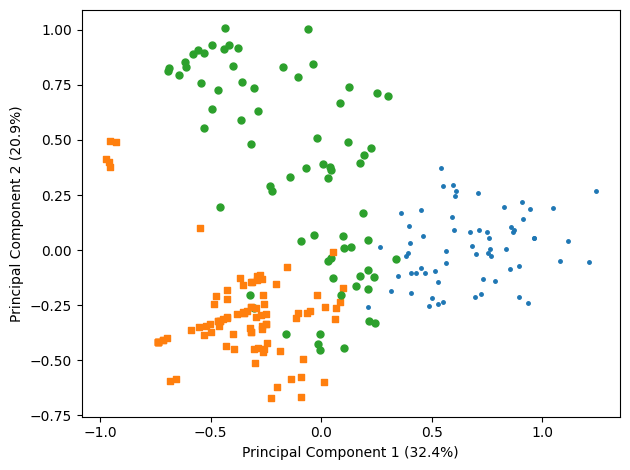

In [56]:
display_results_fuzzy_partition(X, scad1_models, numeric_labels)

# SCAD2

In [59]:
%%capture
scad2_models = np.array([])
for i in range(10):
    model = scad2(X, c, verbose=True, init="None", epsilon=1e-5)
    scad2_models = np.append(scad2_models, model)
scad2_models = sorted(scad2_models, key = lambda model : model['obj_func'])


J values: [0.16636580567625103, 0.16637402867744405, 0.16640911535791264, 0.16649194259603828, 0.1665227589346392, 0.16672325635264537, 0.16672444540489045, 0.1667244821071264, 0.16672854330155623, 0.16672992480919094]
ARI values: [0.05443773710479071, 0.05403935388561198, 0.05403935388561198, 0.053725906808387854, 0.05783817373404162, 0.06522642298557575, 0.06522642298557575, 0.06522642298557575, 0.06987039182314098, 0.06987039182314098]
NMI values: [0.05448512895307969, 0.05383446889025061, 0.05383446889025061, 0.052436589326068005, 0.05503155113556265, 0.06091443694308784, 0.06091443694308784, 0.06091443694308784, 0.06496145926869136, 0.06496145926869136]


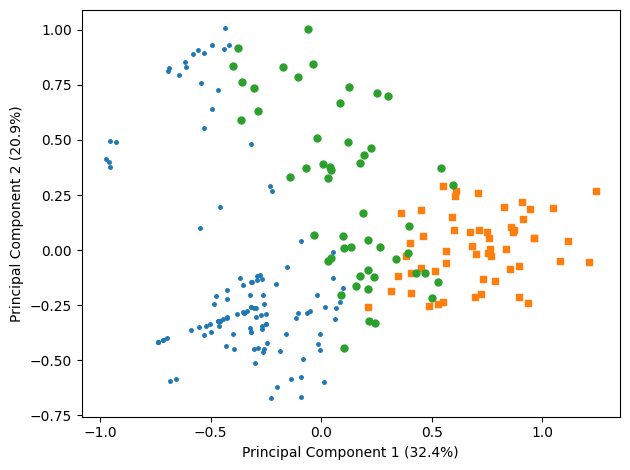

In [60]:
display_results_fuzzy_partition(X, scad2_models, numeric_labels)

# IFWFCM - Xing et al. 2014

In [64]:
%%capture
ifwfcm_models = np.array([])
for i in range(10):
    model = ifwfcm_xing2014(X, c, verbose=True, init="None", epsilon=1e-5)
    ifwfcm_models = np.append(ifwfcm_models, model)
ifwfcm_models = sorted(ifwfcm_models, key = lambda model : model['obj_func'])

J values: [0.21083346976540657, 0.21087500776649593, 0.21087707052804056, 0.2108783708195024, 0.21088110791856646, 0.2108823713348022, 0.21088566764912195, 0.21088933455169528, 0.21089066604767795, 0.21089086237979632]
ARI values: [0.1409819202649665, 0.14749772457990584, 0.14749772457990584, 0.14749772457990584, 0.14749772457990584, 0.14749772457990584, 0.14145161773758955, 0.14145161773758955, 0.14145161773758955, 0.14145161773758955]
NMI values: [0.1276830603174253, 0.13592206360618286, 0.13592206360618286, 0.13592206360618286, 0.13592206360618284, 0.13592206360618284, 0.12905869537029935, 0.12905869537029935, 0.12905869537029935, 0.12905869537029935]


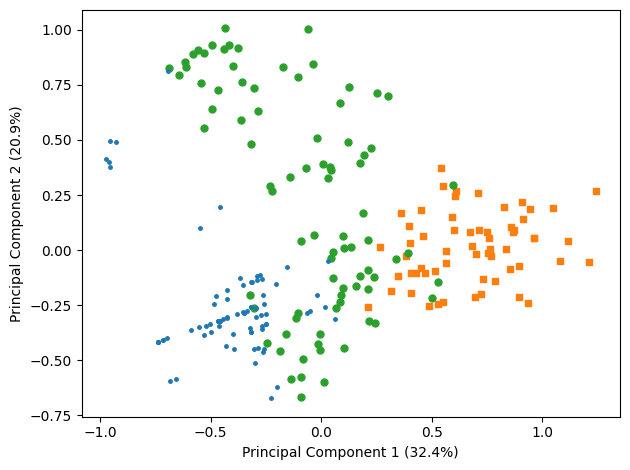

In [65]:
display_results_fuzzy_partition(X, ifwfcm_models, numeric_labels)

# IFWFCM_KD Xing 2014

In [66]:
%%capture
ifwfcm_kd_models = np.array([])
for i in range(10):
    model = ifwfcm_kd_xing2014(X, c, verbose=True, epsilon=1e-5, init="None")
    ifwfcm_kd_models = np.append(ifwfcm_kd_models, model)
ifwfcm_kd_models = sorted(ifwfcm_kd_models, key = lambda model : model['obj_func'])

J values: [3.1646851079917813, 3.164958202404432, 3.1649598521748645, 3.164960893522949, 3.1649655047626384, 3.1649658647961685, 3.1649678207624805, 3.16497072135308, 3.1649713740265693, 3.1649728837776863]
ARI values: [0.14749772457990584, 0.14749772457990584, 0.14749772457990584, 0.14749772457990584, 0.14749772457990584, 0.14145161773758955, 0.14749772457990584, 0.14145161773758955, 0.14145161773758955, 0.14145161773758955]
NMI values: [0.13592206360618286, 0.13592206360618286, 0.13592206360618284, 0.13592206360618286, 0.13592206360618286, 0.12905869537029935, 0.13592206360618284, 0.12905869537029935, 0.12905869537029935, 0.12905869537029935]


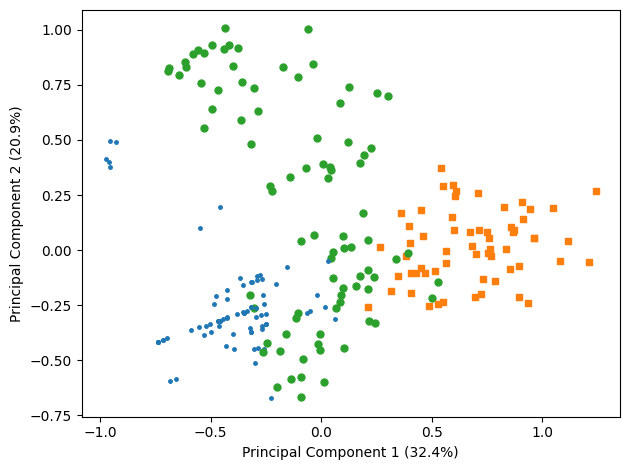

In [67]:
display_results_fuzzy_partition(X, ifwfcm_kd_models, numeric_labels)